In [1]:
import os
import sys

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm 

In [2]:
batch_size = 128
num_workers = 2
n_epoch = 100
z_dim = 100 # 噪音向量的维度
learning_rate = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 模型的保存路径，在Google Colab中，若挂在了Google Drive，则模型会被保存到Google Drive上
ckpt_dir = '/kaggle/working/' 
faces_path = "/kaggle/input/animebest/faces"  # 数据集所在的目录

print("Device: ", device) # 打印一下设备，防止训练半天发现是在CPU上做的

Device:  cuda


In [3]:
class CrypkoDataset(Dataset):
    def __init__(self, img_path='./faces'):
        self.fnames = [img_path + '/' + img for img in os.listdir(img_path)]

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            # 这里将图片缩放到了均值为0.5，方差为0.5的区间，本质是执行了 (x-0.5)/0.5
            # 详情可参考：https://blog.csdn.net/zhaohongfei_358/article/details/117910661
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ])

        self.num_samples = len(self.fnames)


    def __getitem__(self, idx):
        fname = self.fnames[idx]
        img = torchvision.io.read_image(fname)
        img = self.transform(img)
        return img


    def __len__(self):
        return self.num_samples

In [4]:
dataset = CrypkoDataset(faces_path)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

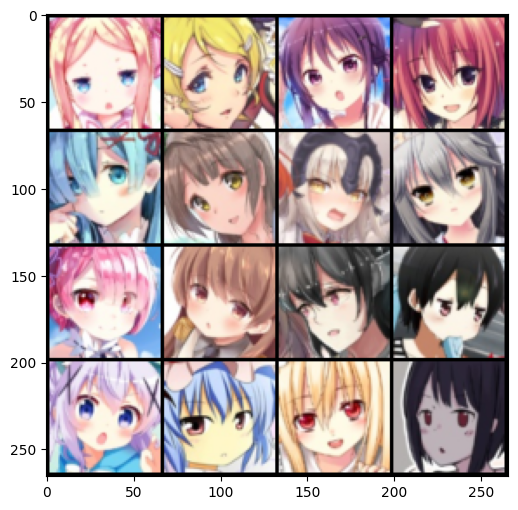

In [5]:
dataset.__getitem__(0).size(), len(dataset)
images = [(dataset[i] + 1) / 2 for i in range(16)]  # 拿出16张图片
grid_img = torchvision.utils.make_grid(images, nrow=4)  # 将其组合成一个4x4的网格
plt.figure(figsize=(6, 6))
plt.imshow(grid_img.permute(1, 2, 0)) # plt接收的图片通道要在最后，所以permute一下
plt.show()

In [6]:
class Generator(nn.Module):
    """
    输入Shape为(N, in_dim)，N为batch_size, in_dim是随机向量的维度
    输出Shape为(N, 3, 64, 64)，即生成N张64x64的彩色图像
    """

    def __init__(self, in_dim, dim=64):
        super(Generator, self).__init__()

        def dconv_bn_relu(in_dim, out_dim):
            return nn.Sequential(
                nn.ConvTranspose2d(in_dim, out_dim, 5, 2,
                                   padding=2, output_padding=1, bias=False),
                nn.BatchNorm2d(out_dim),
                nn.ReLU()
            )

        # 1. 先用线性层将随机向量变成 dim*8 个通道，大小为4x4的图片
        self.l1 = nn.Sequential(
            nn.Linear(in_dim, dim * 8 * 4 * 4, bias=False),
            nn.BatchNorm1d(dim * 8 * 4 * 4),
            nn.ReLU()
        )

        # 2. 然后就一直反卷积，不断的将图片变大，同时通道不断减小，最终变成一个3通道，64x64大小的图片
        self.l2_5 = nn.Sequential(
            dconv_bn_relu(dim * 8, dim * 4),
            dconv_bn_relu(dim * 4, dim * 2),
            dconv_bn_relu(dim * 2, dim),
            nn.ConvTranspose2d(dim, 3, 5, 2, padding=2, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        y = self.l1(x)
        y = y.view(y.size(0), -1, 4, 4)
        y = self.l2_5(y)
        return y

In [7]:
class Discriminator(nn.Module):
    """
    输入Shape为(N, 3, 64, 64)，即N张64x64的彩色图片
    输出Shape为(N,), 即这N个图片每张图片的真实率，越接近1表示Discriminator越觉得它是真的
    """

    def __init__(self, in_dim=3, dim=64): # 注意这里的in_dim是指的图片的通道数，所以是3
        super(Discriminator, self).__init__()

        def conv_bn_lrelu(in_dim, out_dim):
            return nn.Sequential(
                nn.Conv2d(in_dim, out_dim, 5, 2, 2),
                nn.BatchNorm2d(out_dim),
                nn.LeakyReLU(0.2),
            )

        # 就是一堆卷积一直卷，把原始的图片最终卷成一个数字
        self.ls = nn.Sequential(
            nn.Conv2d(in_dim, dim, 5, 2, 2),
            nn.LeakyReLU(0.2),
            conv_bn_lrelu(dim, dim * 2),
            conv_bn_lrelu(dim * 2, dim * 4),
            conv_bn_lrelu(dim * 4, dim * 8),
            nn.Conv2d(dim * 8, 1, 4),
            nn.Sigmoid(),
        )

    def forward(self, x):
        y = self.ls(x)
        y = y.view(-1)
        return y

In [8]:
G = Generator(in_dim=z_dim)
D = Discriminator()
G = G.to(device)
D = D.to(device)
criterion = nn.BCELoss()
opt_D = torch.optim.Adam(D.parameters(), lr=learning_rate)
opt_G = torch.optim.Adam(G.parameters(), lr=learning_rate)

In [ ]:
steps = 0
log_after_step = 50 # 多少步记录一次Loss

# 用于评估阶段的z向量
z_sample = Variable(torch.randn(100, z_dim)).to(device)

for e, epoch in enumerate(range(n_epoch)):
    total_loss_D = 0
    total_loss_G = 0

    for i, data in enumerate(tqdm(dataloader, desc='Epoch {}: '.format(e))):
        imgs = data
        imgs = imgs.to(device)

        # 重新获取batch_size，因为到最后一组的时候，可能凑不够
        batch_size = imgs.size(0)

        # ============================================
        #  训练Discriminator
        # ============================================
        # 1. 得到一批随机的噪音向量 z
        z = Variable(torch.randn(batch_size, z_dim)).to(device)
        # 2. 得到真实(real)的图片
        r_imgs = Variable(imgs).to(device)
        # 3. 使用 Generator生成一批假(fake)图片
        f_imgs = G(z)

        # 构建标签，真实图片的标签都为1，假图片的标签都为0
        r_label = torch.ones((batch_size, )).to(device)
        f_label = torch.zeros((batch_size, )).to(device)

        # 用Discriminator对真实图片和假图片进行判别
        r_logit = D(r_imgs.detach())
        f_logit = D(f_imgs.detach())

        # 计算Discriminator的损失
        r_loss = criterion(r_logit, r_label)
        f_loss = criterion(f_logit, f_label)
        loss_D = (r_loss + f_loss) / 2
        total_loss_D += loss_D

        # 对Discriminator进行反向传播
        D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # ============================================
        # 训练Generator
        # ============================================
        # 1. 生成N张假图片
        z = Variable(torch.randn(batch_size, z_dim)).to(device)
        f_imgs = G(z)

        # 2. 让Discriminator判别这些假图片
        f_logit = D(f_imgs)

        # 3. 计算损失，这里Generator是希望图片越真越好，所以参数是f_logit和r_label
        loss_G = criterion(f_logit, r_label)
        total_loss_G += loss_G

        # 对Generator进行反向传播
        G.zero_grad()
        loss_G.backward()
        opt_G.step()

        steps += 1

    # 每一个epoch后，生成一张一组图片看看效果
    G.eval()

    # 用Generator生成图片，并进行去除标准化，然后保存到logs目录下
    f_imgs_sample = (G(z_sample).data + 1) / 2.0
    if not os.path.exists('logs'):
        os.makedirs('logs')
    filename = os.path.join('logs', f'Epoch_{epoch + 1:03d}.jpg')
    # 将生成的图片保存下来
    torchvision.utils.save_image(f_imgs_sample, filename, nrow=10)
    print(f' | Save some samples to {filename}.')

    # 展示一下生成的图片
    grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow=10)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

    # 将Generator重新调整为训练模式
    G.train()

    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)
    # 每5个epoch保存一次模型
    if (e + 1) % 5 == 0 or e == 0:
        # Save the checkpoints.
        torch.save(G.state_dict(), os.path.join(ckpt_dir, 'G_{}.pth'.format(steps)))
        torch.save(D.state_dict(), os.path.join(ckpt_dir, 'D_{}.pth'.format(steps)))

Epoch 0:  59%|█████▉    | 328/558 [02:13<01:16,  3.01it/s]